In [22]:
!pip install tensorflow numpy matplotlib


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

(x_train, y_train), _ = mnist.load_data()
x_train = x_train.astype("float32") / 255.0

def generate_sequences(images, labels, seq_len=5, num_samples=5000):
    data, targets = [], []
    for _ in range(num_samples):
        idxs = np.random.choice(len(images), seq_len)
        seq_images = images[idxs]
        seq_labels = labels[idxs]
        concat_image = np.hstack(seq_images)
        data.append(concat_image)
        targets.append(seq_labels)
    return np.array(data)[..., np.newaxis], np.array(targets)

x_seq, y_seq = generate_sequences(x_train, y_train)


Shape of generated image sequences: (5000, 28, 140, 1)
Shape of generated label sequences: (5000, 5)


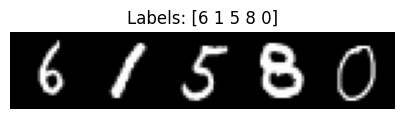

In [24]:


import matplotlib.pyplot as plt
import numpy as np
print("Shape of generated image sequences:", x_seq.shape)
print("Shape of generated label sequences:", y_seq.shape)

# Display the first generated sequence and its labels
plt.figure(figsize=(12, 1))
plt.imshow(np.squeeze(x_seq[0]), cmap='gray')
plt.title(f"Labels: {y_seq[0]}")
plt.axis('off')
plt.show()

In [25]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(28, 28 * 5, 1), name='image')

# CNN feature extractor #3 pairs of Conv2D and MaxPooling to identify patterns and reduce the size of the maps
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Prepare for RNN
shape = x.shape
x = layers.Reshape(target_shape=(shape[2], shape[1] * shape[3]))(x)  # (timesteps, features)

# RNN (BiLSTM)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Dense(11, activation='softmax')(x)  # 10 digits + blank

model = models.Model(inputs=input_img, outputs=x)

In [26]:
class CTCLossLayer(layers.Layer):
    def call(self, y_true, y_pred):
        # Compute CTC Loss
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred


In [27]:
labels = layers.Input(name='label', shape=(5,), dtype='int32')
output = CTCLossLayer()(labels, model.output)

training_model = models.Model(inputs=[input_img, labels], outputs=output)
training_model.compile(optimizer='adam')


In [28]:
training_model.fit(
    x=[x_seq, y_seq],
    y=np.zeros(len(x_seq)),
    epochs=30,
    batch_size=32
)


Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 456.0975
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 247.6368
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 90.1435
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 64.5160
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 46.2506
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 36.1697
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 27.2727
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 21.3147
Epoch 9/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 17.5011
Epoch 10/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 12.0536
Epoch 11/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 9.4684
Epoch 12/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 6.8294
Epoch 13/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 4.7010
Epoch 14/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 3.0773
Epoch 15/30
157/157 ━━━━━━━━━━━

In [29]:
from tensorflow.keras.backend import ctc_decode
decoded, _ = ctc_decode(model.predict(x_seq[:10]), input_length=np.ones(10) * model.output.shape[1])
print("Predicted sequences:")
for seq in decoded[0].numpy():
    print(seq[seq != -1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
Predicted sequences:
[6 1 5 8 0]
[3 1 5 0 8]
[8 3 1 7 1]
[0 6 5 2 9]
[7 3 5 2 5]
[0 7 2 2 3]
[3 4 1 7 5]
[1 3 4 0 0]
[4 1 5 2 6]
[3 0 4 0 5]


In [30]:
from tensorflow.keras.backend import ctc_decode

def decode_predictions(y_pred):
    # y_pred: logits from model.predict()
    input_length = np.ones(y_pred.shape[0]) * y_pred.shape[1]
    decoded, _ = ctc_decode(y_pred, input_length=input_length)
    return decoded[0].numpy()

def sequence_accuracy(y_true, y_pred_decoded):
    correct = 0
    for true, pred in zip(y_true, y_pred_decoded):
        pred = pred[pred != -1]  # remove CTC blanks
        if np.array_equal(true, pred[:len(true)]):  # simple match
            correct += 1
    return correct / len(y_true)


In [31]:
# Get logits
y_pred = model.predict(x_seq[:100])

# Decode predictions
y_pred_decoded = decode_predictions(y_pred)

# Compute accuracy
acc = sequence_accuracy(y_seq[:100], y_pred_decoded)
print(f"Sequence-level Accuracy: {acc * 100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Sequence-level Accuracy: 100.00%
